In [92]:
import pandas as pd
from unidecode import unidecode

In [93]:
# load the data
df = pd.read_csv('menus.csv')

In [94]:
# convert prices to numeric
df['price'] = df['price'].apply(lambda x: pd.to_numeric(x[1:], errors='coerce'))

In [95]:
non_numeric_count = df['price'].isna().sum()
f"Number of non-numerical values in 'price' column: {non_numeric_count}"

"Number of non-numerical values in 'price' column: 19"

In [96]:
# Remove the non-numerical values
df = df.dropna(subset=['price'])

In [97]:
zero_count = (df['price'] == 0).sum()
f"Number of 0s in 'price' column: {zero_count}"

"Number of 0s in 'price' column: 7"

In [98]:
# Remove 0s, since these are free stuff that are generally included anywhere
df = df[df['price'] != 0]

In [99]:
# Filter out any non-standard characters for easier matching with our restaurants dataset
df['name'] = (df['name']
              .apply(unidecode)
              .replace(r'[^a-zA-Z0-9\-\s\(\)]', '', regex=True)
              .replace(r'\s+', ' ', regex=True)
              .str.strip())

In [100]:
# Clarify that the price is Uber local_price
df = df.rename(columns={'price': 'uber_price'})

In [101]:
df.head()

,restaurant,name,uber_price
0,Nick The Greek - Davis,Chicken Gyro Pita,14.95
1,Nick The Greek - Davis,BeefLamb Gyro Pita,14.95
2,Nick The Greek - Davis,Falafel Pita,14.95
3,Nick The Greek - Davis,BeefLamb Gyro Pita,14.95
4,Nick The Greek - Davis,BeefLamb Gyro Pita Combo,19.75


In [102]:
# get the restaurant names so we match the correct menu item
df['restaurant'].unique()

array(['Nick The Greek - Davis', 'Jack in the Box (337 G St.)',
       'Local Kitchens - Davis', 'Wingstop (408 G ST)',
       'Blaze Pizza (212 F Street)'], dtype=object)

In [103]:
# now add all local restaurants
restaurants = [
  ('blaze', 'Blaze Pizza (212 F Street)'),
  ('jack_in_the_box', 'Jack in the Box (337 G St.)'),
  ('local_kitchens', 'Local Kitchens - Davis'),
  ('nick_the_greek', 'Nick The Greek - Davis'),
  ('wings', 'Wingstop (408 G ST)'),
]

new_dfs = []

for file_name, restaurant in restaurants:
  df1 = df[df['restaurant'] == restaurant]
  df2 = pd.read_csv(f'{file_name}.csv')
  df2 = df2.rename(columns={"Price": "local_price"})

  # local kitchens is in pennies
  if file_name == 'local_kitchens':
    df2['local_price'] = pd.to_numeric(df2['local_price'], errors='coerce') / 100

  # Filter out any non-standard characters for easier matching with our restaurants dataset
  df2['Name'] = (df2['Name']
                 .apply(unidecode)
                 .replace(r'[^a-zA-Z0-9\-\s\(\)]', '', regex=True)
                 .replace(r'\s+', ' ', regex=True)
                 .str.strip())

  df1 = df1.merge(
    df2,
    left_on='name',
    right_on='Name',
    how='left',
    suffixes=('', ''),
  )

  new_dfs.append(df1)

df = pd.concat(new_dfs)
df.head()

,restaurant,name,uber_price,Category,Name,local_price,Description,Base Calories,Max Calories,Brand
0,Blaze Pizza (212 F Street),Feed The Family 5,53.00,What's Hot,Feed The Family 5,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...,NaN,NaN,NaN
1,Blaze Pizza (212 F Street),Feed The Family 5,53.00,Digital Deals,Feed The Family 5,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...,NaN,NaN,NaN
2,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,What's Hot,Green Goddess Chop Salad - Side,7.19,This fresh and vibrant salad that's packed wit...,NaN,NaN,NaN
3,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,Cheesy Breads & Salads,Green Goddess Chop Salad - Side,7.19,This fresh and vibrant salad that's packed wit...,NaN,NaN,NaN
4,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Entree,13.41,What's Hot,Green Goddess Chop Salad - Entree,10.99,This fresh and vibrant salad that's packed wit...,NaN,NaN,NaN


In [104]:
f'There are {df['local_price'].isna().sum()} local restaurant prices missing'

'There are 52 local restaurant prices missing'

In [105]:
df[df['local_price'].isna()].head()

,restaurant,name,uber_price,Category,Name,local_price,Description,Base Calories,Max Calories,Brand
12,Blaze Pizza (212 F Street),Vegan Pizza (11-inch),19.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,Blaze Pizza (212 F Street),Vegetarian Pizza (11-inch),21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,Blaze Pizza (212 F Street),Coke Bottle (20oz591ml),4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,Blaze Pizza (212 F Street),Diet Coke Bottle (20oz591ml),3.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,Blaze Pizza (212 F Street),Sprite Bottle (20oz591ml),4.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# I inspected these values, and couldn't match them manually, so we will just drop them
df = df[~df['local_price'].isna()]

In [107]:
df = df.drop(columns=["Base Calories", "Max Calories", "Brand", "Name"])

In [108]:
df.head()

,restaurant,name,uber_price,Category,local_price,Description
0,Blaze Pizza (212 F Street),Feed The Family 5,53.00,What's Hot,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...
1,Blaze Pizza (212 F Street),Feed The Family 5,53.00,Digital Deals,45.0,3 BYO 11-inch Pizzas + Your Choice any Two: En...
2,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,What's Hot,7.19,This fresh and vibrant salad that's packed wit...
3,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Side,8.53,Cheesy Breads & Salads,7.19,This fresh and vibrant salad that's packed wit...
4,Blaze Pizza (212 F Street),Green Goddess Chop Salad - Entree,13.41,What's Hot,10.99,This fresh and vibrant salad that's packed wit...


In [109]:
f'We now have {df.shape[0]} entries to compare'

'We now have 377 entries to compare'

In [21]:
# Convert the local_price col to numeric
df['local_price'] = pd.to_numeric(df['local_price'], errors='coerce')

f'There are {df['local_price'].isna().sum()} unsuccessful converted values'

'There are 0 unsuccessful converted values'

# Data Analysis

In [128]:
df = pd.read_csv('data.csv')

In [129]:
# Show the summary statistics for the different prices overall
df[['uber_price', 'local_price']].describe()

,uber_price,local_price
count,377.000000,377.000000
mean,12.033024,10.190743
std,8.630545,7.343377
min,0.490000,0.490000
25%,6.050000,5.100000
50%,10.490000,8.750000
75%,15.610000,13.990000
max,57.490000,49.990000


In [130]:
df["restaurant"] = df["restaurant"].str.replace(r"\s*\(.*?\)|\s*-\s*Davis", "", regex=True)

In [131]:
df["restaurant"].unique()

array(['Blaze Pizza', 'Jack in the Box', 'Local Kitchens',
       'Nick The Greek', 'Wingstop'], dtype=object)

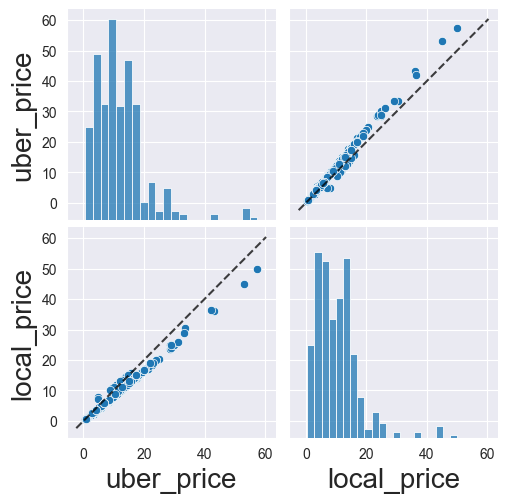

In [175]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the pairplot
g = sns.pairplot(df[['uber_price', 'local_price']])

FONT_SIZE = 20

# Add y = x dashed line to each subplot
for ax in g.axes.flat:
  if ax is not None:
    x_var = ax.get_xlabel()
    y_var = ax.get_ylabel()

    ax.set_xlabel(x_var, fontsize=FONT_SIZE)  # Increase x-label font size
    ax.set_ylabel(y_var, fontsize=FONT_SIZE)  # Increase y-label font size

    if x_var == '' or y_var == '':
      continue

    lims = [
      min(ax.get_xlim()[0], ax.get_ylim()[0]),  # Get lower limit
      max(ax.get_xlim()[1], ax.get_ylim()[1]),  # Get upper limit
    ]
    ax.plot(lims, lims, 'k--', alpha=0.75)

# Show the plot
plt.show()


In [133]:
df[df["local_price"] > df["uber_price"]].head()

,Unnamed: 0,restaurant,name,uber_price,Category,local_price,Description,markup
50,52,Blaze Pizza,Pesto Garlic Cheesy Bread,4.87,Cheesy Breads & Salads,7.99,"Our classic dough with shredded mozzarella, or...",-0.390488
76,0,Jack in the Box,Big Smashed Jacktm Combo,15.61,What's New,15.78,Two 1/4lb smashed patties made w/ 100% seasone...,-0.010773
77,1,Jack in the Box,Big Smashed Jacktm Combo,15.61,Burger Combos,15.78,Two 1/4lb smashed patties made w/ 100% seasone...,-0.010773
83,7,Jack in the Box,12pc Smoke Show Smoky BBQ Crispy Boneless Wing...,15.61,What's New,15.78,12pc 100% all-white meat Crispy Boneless Wings...,-0.010773
84,8,Jack in the Box,12pc Smoke Show Smoky BBQ Crispy Boneless Wing...,15.61,Chicken Combos,15.78,12pc 100% all-white meat Crispy Boneless Wings...,-0.010773


In [134]:
# calculate the summary statistics for how much more people pay at Uber Eats
df['markup'] = (df['uber_price'] - df['local_price']) / df['local_price']
df['diff'] = df['uber_price'] - df['local_price']
df[['uber_price', 'local_price', 'markup', 'diff']].describe()

,uber_price,local_price,markup,diff
count,377.000000,377.000000,377.000000,377.000000
mean,12.033024,10.190743,0.190037,1.842281
std,8.630545,7.343377,0.102564,1.635732
min,0.490000,0.490000,-0.390488,-3.120000
25%,6.050000,5.100000,0.196000,0.820000
50%,10.490000,8.750000,0.212500,1.780000
75%,15.610000,13.990000,0.250227,2.660000
max,57.490000,49.990000,0.467249,8.000000


/var/folders/1y/4sm5vl2d7_xdd0jwk0tgnhn00000gn/T/ipykernel_8728/1796607339.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["restaurant"], y=df["markup"], palette="Set2")


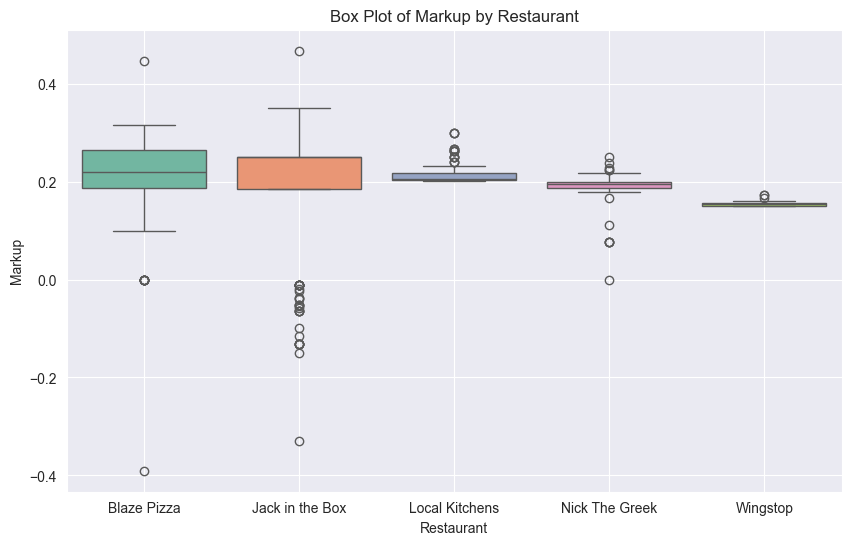

In [135]:
# Group by restaurant and describe the markup statistics
grouped = df.groupby("restaurant")["markup"].describe()

# Convert to a suitable format for box plot
df_boxplot = df.groupby("restaurant")["markup"]

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df["restaurant"], y=df["markup"], palette="Set2")

plt.xlabel("Restaurant")
plt.ylabel("Markup")
plt.title("Box Plot of Markup by Restaurant")
plt.grid(True)

plt.show()

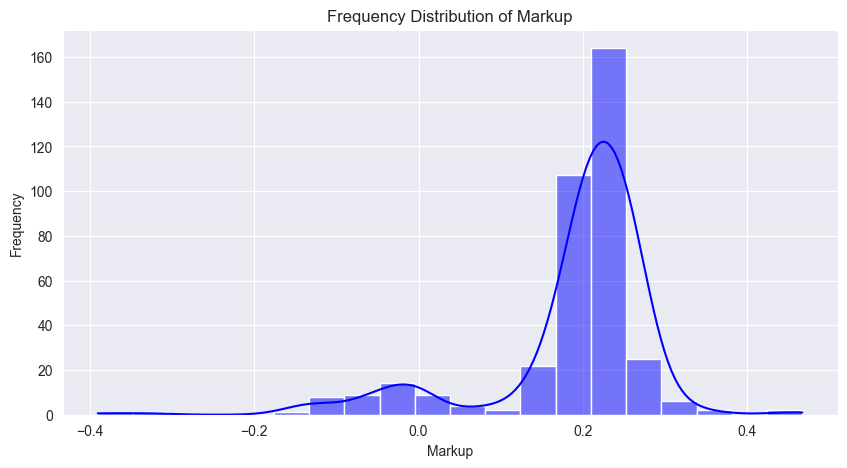

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample dataset (replace this with your actual dataframe)
import pandas as pd

# Plot the frequency distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['markup'], bins=20, kde=True, color='blue')

plt.xlabel('Markup')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Markup')
plt.grid(True)

plt.show()

In [137]:
df.to_csv('data.csv')

# Compare between restaurants

In [146]:
df = pd.read_csv('data.csv')

In [176]:
# data is normal?
from scipy.stats import shapiro

# Assume df is your DataFrame
stat, p = shapiro(df['markup'])

print(f"Shapiro-Wilk Test: Statistic={stat}, p-value={p}")

if p > 0.05:
    print("Data appears to be normally distributed.")
else:
    print("Data does not appear to be normally distributed.")

Shapiro-Wilk Test: Statistic=0.7193358570303943, p-value=1.099467874104901e-24
Data does not appear to be normally distributed.


In [182]:
from scipy.stats import levene

unique_restaurants = df['restaurant'].unique()
stat, p = levene(*(df[df['restaurant'] == restaurant]['markup'] for restaurant in unique_restaurants))
print(f"Levene’s Test: Statistic={stat}, p-value={p}")

if p > 0.05:
    print("Variance is likely constant (homoscedasticity).")
else:
    print("Variance is not constant (heteroscedasticity).")

Levene’s Test: Statistic=10.046437746575052, p-value=9.896870258228696e-08
Variance is not constant (heteroscedasticity).


In [147]:
df.groupby("restaurant")["markup"].describe().T

restaurant,Blaze Pizza,Jack in the Box,Local Kitchens,Nick The Greek,Wingstop
count,76.000000,132.000000,110.000000,37.000000,22.000000
mean,0.194648,0.174583,0.215768,0.179681,0.155585
std,0.106206,0.146617,0.022306,0.053226,0.006721
min,-0.390488,-0.330508,0.200692,0.000000,0.150030
25%,0.186370,0.184237,0.203846,0.187500,0.150989
50%,0.220180,0.250218,0.205357,0.196000,0.153436
75%,0.263760,0.250537,0.216667,0.200000,0.155657
max,0.445910,0.467249,0.300000,0.250000,0.171920


In [183]:
# Get the number of outliers
# Group by restaurant and calculate Q1, Q3, and IQR
grouped = df.groupby("restaurant")["markup"]
q1 = grouped.quantile(0.25)
q3 = grouped.quantile(0.75)
iqr = q3 - q1

# Compute outlier thresholds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Merge thresholds with the original DataFrame
df = df.merge(lower_bound.rename("lower_bound"), on="restaurant")
df = df.merge(upper_bound.rename("upper_bound"), on="restaurant")

# Identify outliers
df["is_outlier"] = (df["markup"] < df["lower_bound"]) | (df["markup"] > df["upper_bound"])

# Drop unnecessary threshold columns for a cleaner result
df = df.drop(columns=["lower_bound", "upper_bound"])

In [191]:
df["is_outlier"].sum()

np.int64(76)

In [148]:
from scipy.stats import kruskal

restaurants = df["restaurant"].unique()

In [149]:
stat, p_value = kruskal(
  *(df[df['restaurant'] == restaurant]['markup'] for restaurant in restaurants)
)

In [150]:
stat

np.float64(67.6297835892326)

In [151]:
p_value  # The p value is < 0.05, which means that there is significant difference between markups at restaurants

np.float64(7.180325581749202e-14)

# Local pricing vs Markup

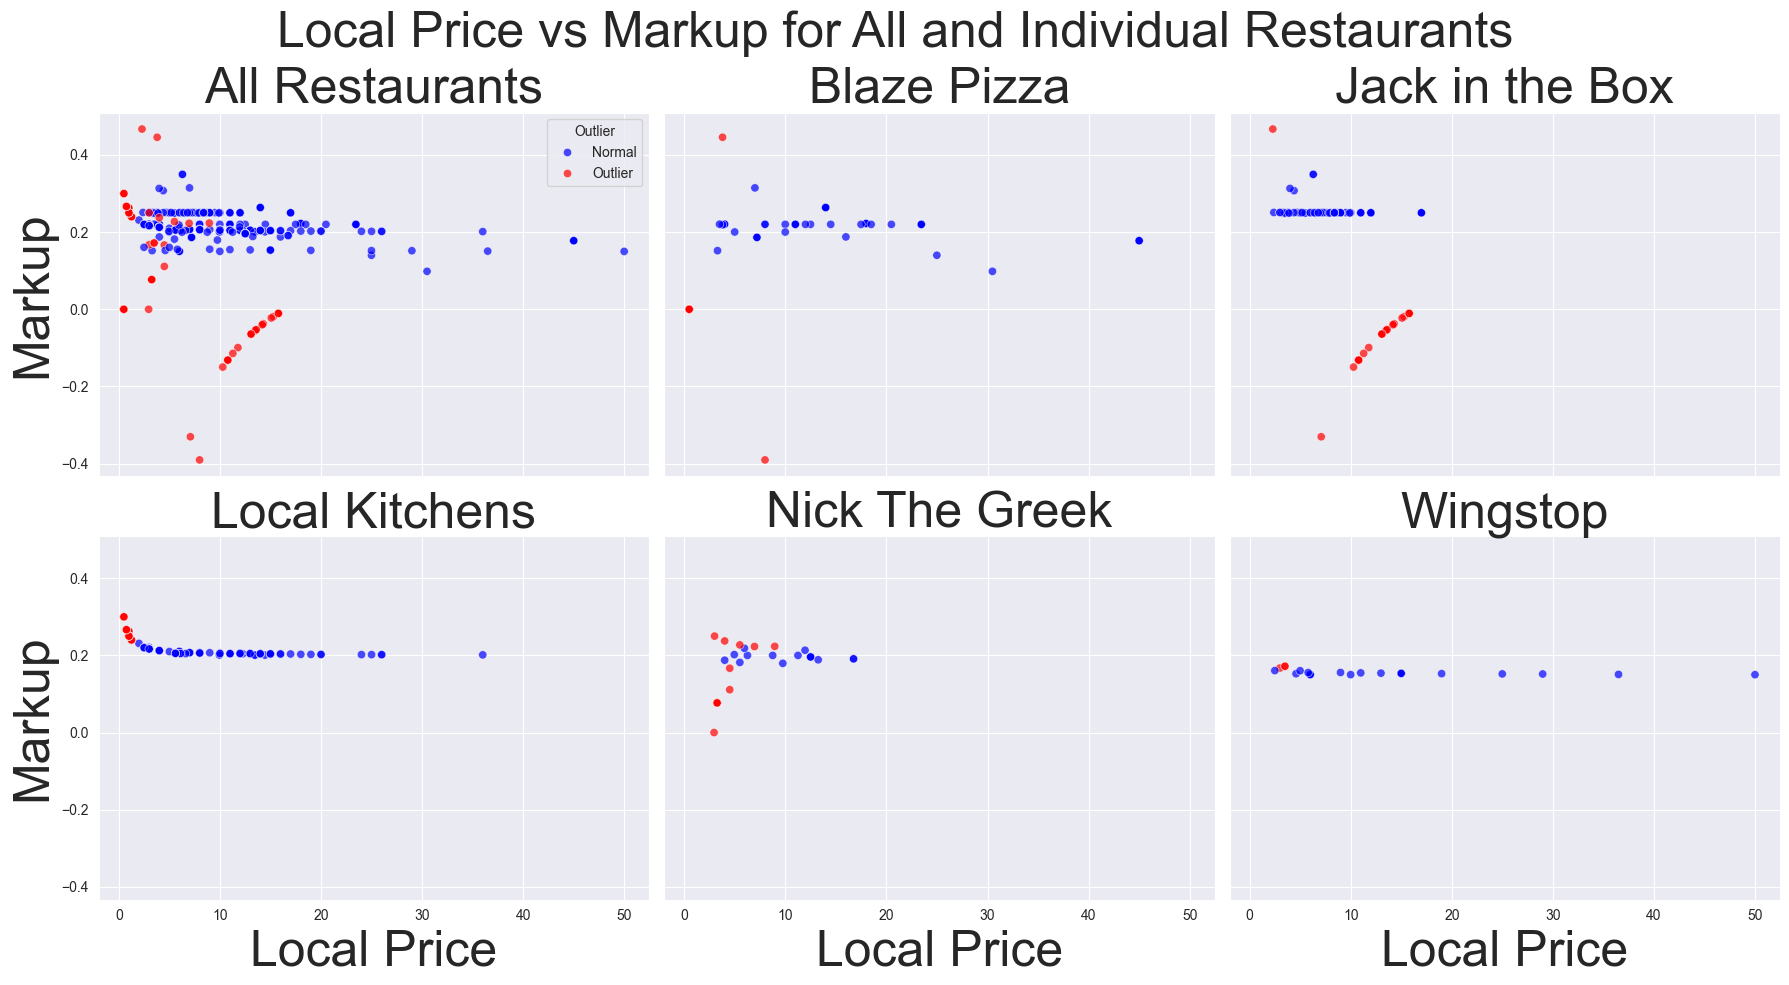

In [199]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the first 5 unique restaurants
unique_restaurants = df['restaurant'].unique()[:5]

FONT_SIZE = 36

# Create a figure with 2 rows and 3 columns (1 for all restaurants + 5 for individual ones)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Define colors for normal and outlier points
colors = {False: "blue", True: "red"}

# Plot all restaurants in the first subplot (row 1, col 1)
ax = axes[0, 0]
sns.scatterplot(
    x=df['local_price'],
    y=df['markup'],
    hue=df['is_outlier'],  # Use the boolean column directly
    palette=colors,  # Map True/False to colors
    alpha=0.7,
    ax=ax
)
ax.set_title("All Restaurants", fontsize=FONT_SIZE)
ax.set_xlabel("Local Price", fontsize=FONT_SIZE)
ax.set_ylabel("Markup", fontsize=FONT_SIZE)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Normal", "Outlier"], title="Outlier", loc="upper right")

# Plot individual restaurants in the remaining 5 subplots
for i, restaurant in enumerate(unique_restaurants):
    row, col = divmod(i + 1, 3)  # Offset by 1 to place all restaurants in (0,0)
    ax = axes[row, col]

    subset = df[df['restaurant'] == restaurant]
    sns.scatterplot(
        x=subset['local_price'],
        y=subset['markup'],
        hue=subset['is_outlier'],  # Use the boolean column directly
        palette=colors,  # Map True/False to colors
        alpha=0.7,
        ax=ax
    )

    ax.set_title(restaurant, fontsize=FONT_SIZE)
    ax.set_xlabel("Local Price", fontsize=FONT_SIZE)
    if col == 0:  # Only set y-label for first column
        ax.set_ylabel("Markup", fontsize=FONT_SIZE)

    ax.legend().set_visible(False)  # Hide legends in individual plots

# Adjust layout
plt.suptitle("Local Price vs Markup for All and Individual Restaurants", fontsize=FONT_SIZE)
plt.tight_layout()
plt.show()


In [204]:
from sklearn.linear_model import TheilSenRegressor
import numpy as np
import pandas as pd

# Filter out outliers
df_no_outlier = df[df['is_outlier'] == False]

# Dictionary to store results
restaurant_slopes = {}

# Loop over each restaurant and fit Theil-Sen regression
for restaurant, subset in df_no_outlier.groupby("restaurant"):
    X = subset['local_price'].values.reshape(-1, 1)
    y = subset['markup'].values

    # Check if there are enough data points
    if len(X) > 1:  # Theil-Sen requires at least two points
        model = TheilSenRegressor()
        model.fit(X, y)
        restaurant_slopes[restaurant] = model.coef_[0]
    else:
        restaurant_slopes[restaurant] = np.nan  # Not enough data to compute

# Convert to DataFrame for better visualization
slope_df = pd.DataFrame(list(restaurant_slopes.items()), columns=["Restaurant", "Slope"])

# Display results
slope_df

,Restaurant,Slope
0,Blaze Pizza,-0.000003
1,Jack in the Box,-0.000155
2,Local Kitchens,-0.001066
3,Nick The Greek,0.000874
4,Wingstop,-0.000065


In [202]:
from sklearn.linear_model import TheilSenRegressor
import numpy as np
from scipy.stats import percentileofscore

# Filter out outliers
df_no_outlier = df[df['is_outlier'] == False]
X = df_no_outlier['local_price'].values.reshape(-1, 1)
y = df_no_outlier['markup'].values

# Fit Theil-Sen regression
model = TheilSenRegressor()
model.fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_

# Bootstrapping to estimate significance
num_bootstraps = 1000
bootstrap_slopes = []

np.random.seed(42)  # For reproducibility

for _ in range(num_bootstraps):
    sample_indices = np.random.choice(len(X), size=len(X), replace=True)
    X_sample = X[sample_indices]
    y_sample = y[sample_indices]

    model_boot = TheilSenRegressor()
    model_boot.fit(X_sample, y_sample)
    bootstrap_slopes.append(model_boot.coef_[0])

# Compute 95% confidence interval
lower, upper = np.percentile(bootstrap_slopes, [2.5, 97.5])

# Estimate p-value (fraction of slopes crossing zero)
p_value = (percentileofscore(bootstrap_slopes, 0, kind="mean") / 100)

print(f"Theil-Sen Regression Slope: {slope}, Intercept: {intercept}")
print(f"95% Confidence Interval for Slope: ({lower}, {upper})")
print(f"Estimated p-value: {p_value}")

if p_value < 0.05:
    print("Slope is statistically significant (p < 0.05).")
else:
    print("Slope is NOT statistically significant (p >= 0.05).")

Theil-Sen Regression Slope: -0.0009758390110189885, Intercept: 0.24083875883498937
95% Confidence Interval for Slope: (-0.0013509964092711234, -0.000344819395799639)
Estimated p-value: 1.0
Slope is NOT statistically significant (p >= 0.05).


# Price Difference on local priced items

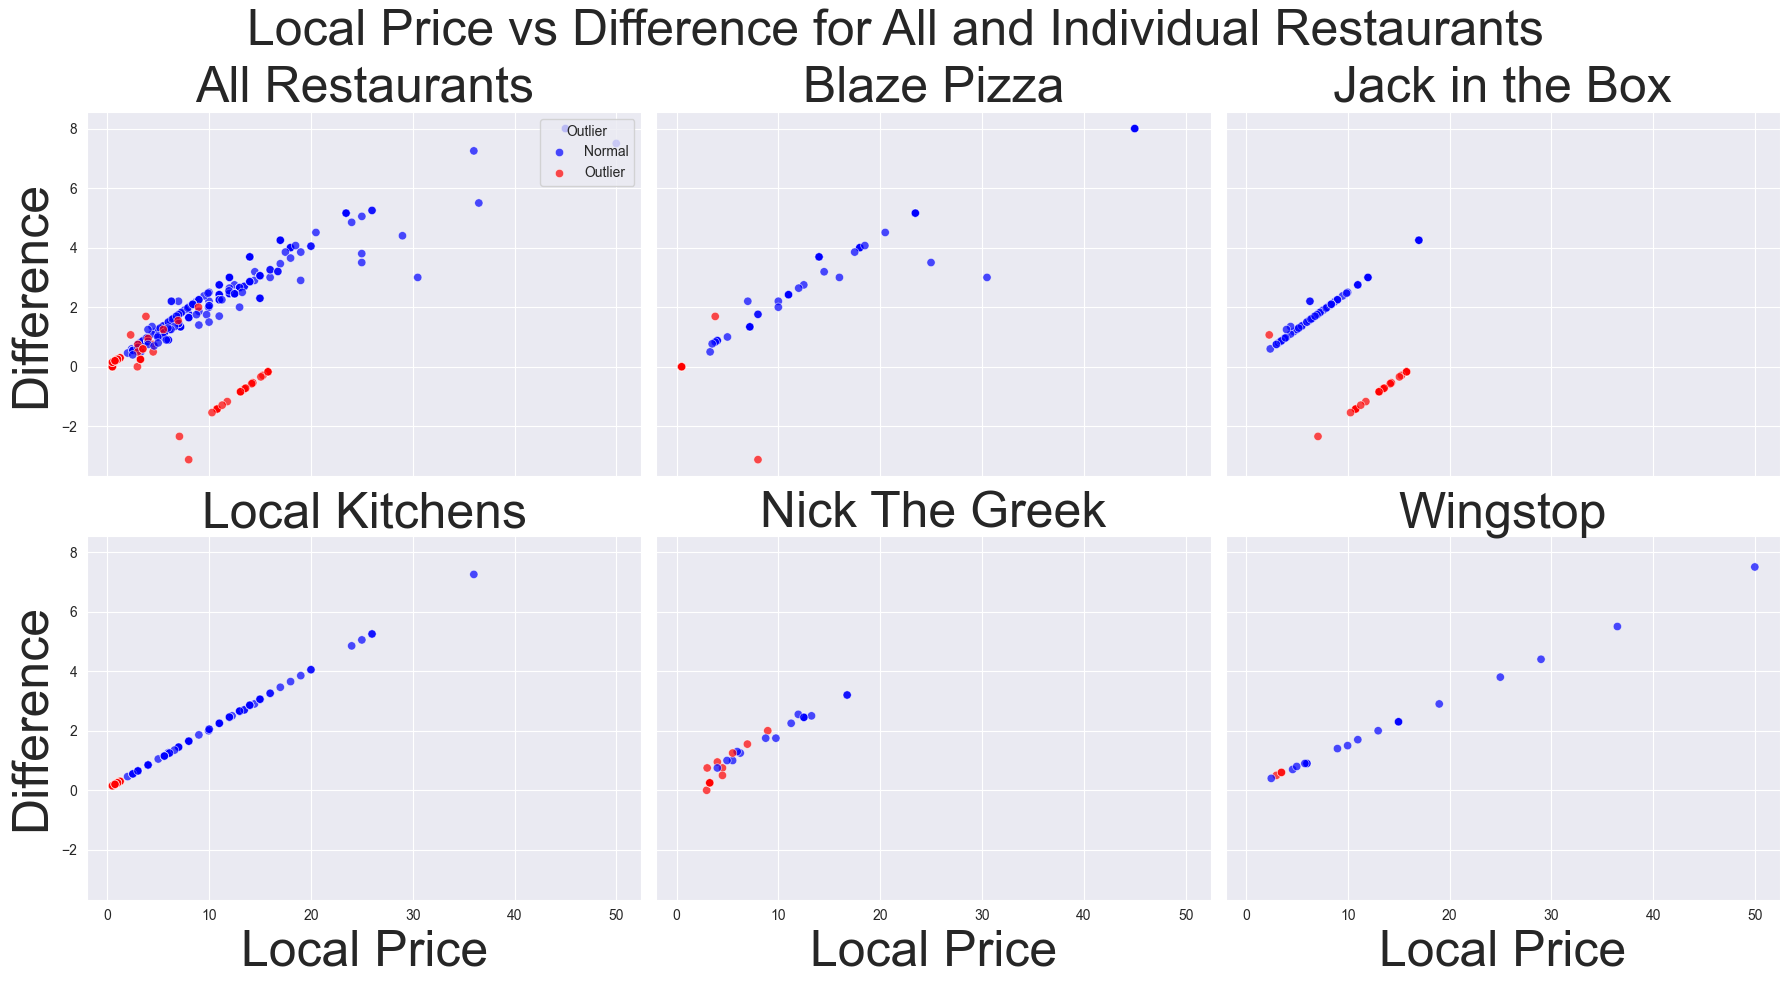

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the first 5 unique restaurants
unique_restaurants = df['restaurant'].unique()[:5]

FONT_SIZE = 36

# Create a figure with 2 rows and 3 columns (1 for all restaurants + 5 for individual ones)
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)

# Define colors for normal and outlier points
colors = {False: "blue", True: "red"}

# Plot all restaurants in the first subplot (row 1, col 1)
ax = axes[0, 0]
sns.scatterplot(
    x=df['local_price'],
    y=df['diff'],
    hue=df['is_outlier'],  # Use the boolean column directly
    palette=colors,  # Assign colors based on outlier status
    alpha=0.7,
    ax=ax
)
ax.set_title("All Restaurants", fontsize=FONT_SIZE)
ax.set_xlabel("Local Price", fontsize=FONT_SIZE)
ax.set_ylabel("Difference", fontsize=FONT_SIZE)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["Normal", "Outlier"], title="Outlier", loc="upper right")

# Plot individual restaurants in the remaining 5 subplots
for i, restaurant in enumerate(unique_restaurants):
    row, col = divmod(i + 1, 3)  # Offset by 1 to place all restaurants in (0,0)
    ax = axes[row, col]

    subset = df[df['restaurant'] == restaurant]
    sns.scatterplot(
        x=subset['local_price'],
        y=subset['diff'],
        hue=subset['is_outlier'],  # Use the boolean column directly
        palette=colors,  # Assign colors based on outlier status
        alpha=0.7,
        ax=ax
    )

    ax.set_title(restaurant, fontsize=FONT_SIZE)
    ax.set_xlabel("Local Price", fontsize=FONT_SIZE)
    if col == 0:  # Only set y-label for the first column
        ax.set_ylabel("Difference", fontsize=FONT_SIZE)

    ax.legend().set_visible(False)  # Hide legends in individual plots

# Adjust layout
plt.suptitle("Local Price vs Difference for All and Individual Restaurants", fontsize=FONT_SIZE)
plt.tight_layout()
plt.show()

# Experimental (Do NOT Include)

In [1]:
import pandas as pd

df = pd.read_csv('data.csv')

In [2]:
# Example food descriptions
food_descriptions = df['name']

In [3]:
food_descriptions

0                      Feed The Family 5
1                      Feed The Family 5
2        Green Goddess Chop Salad - Side
3        Green Goddess Chop Salad - Side
4      Green Goddess Chop Salad - Entree
                     ...                
372                        Veggie Sticks
373                       Side of Flavor
374               52 oz Simply Lemonader
375                Dasani Bottled Waterr
376       Triple Chocolate Chunk Brownie
Name: name, Length: 377, dtype: object

In [4]:
import ollama
import numpy as np


def get_embedding(text):
  response = ollama.embeddings(model="hf.co/CompendiumLabs/bge-base-en-v1.5-gguf", prompt=text)
  return response['embedding']


embeddings = np.array([get_embedding(item) for item in food_descriptions])

/opt/anaconda3/envs/sta141b-project/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


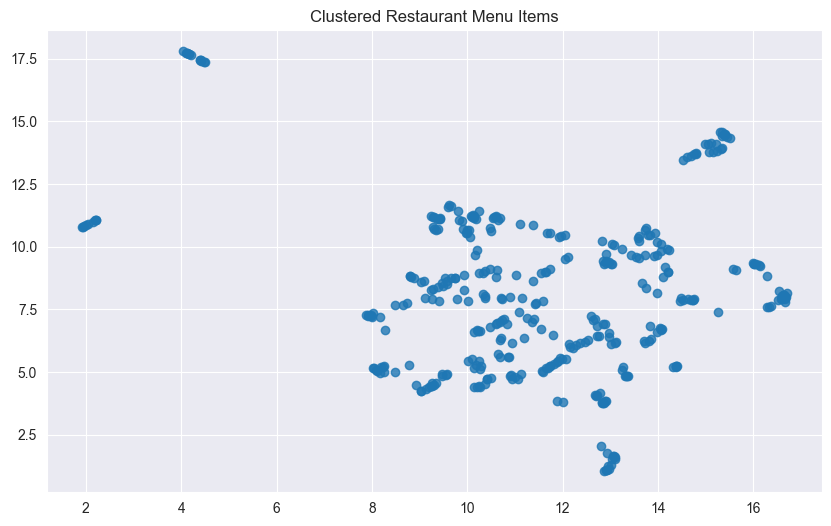

In [5]:
import umap
import matplotlib.pyplot as plt

# Reduce dimensionality for visualization
reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, metric="cosine")
embedding_2d = reducer.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.8)
plt.title("Clustered Restaurant Menu Items")
plt.show()

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

# Normalize embeddings (for cosine similarity)
embeddings_normalized = normalize(embeddings, axis=1)

# Find optimal k using Silhouette Score
best_k = 7
best_score = -1
for k in range(19, 100):  # Test k
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
  labels = kmeans.fit_predict(embeddings_normalized)  # Use normalized embeddings

  score = silhouette_score(embeddings_normalized, labels, metric="cosine")  # Evaluate with cosine similarity
  if score > best_score:
    best_score = score
    best_k = k

print(f"Optimal k: {best_k} (Silhouette Score: {best_score:.4f})")

# Final KMeans clustering with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(embeddings_normalized)

KeyboardInterrupt: 

/opt/anaconda3/envs/sta141b-project/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


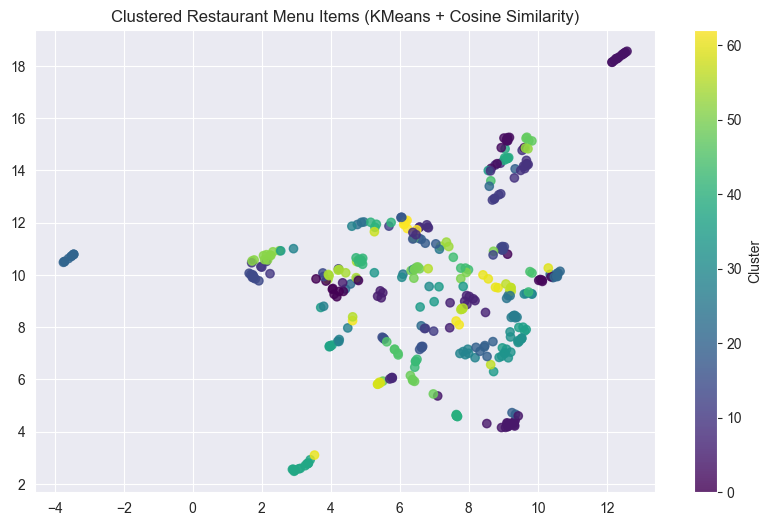

In [17]:
# Reduce dimensionality for visualization
reducer = umap.UMAP(n_neighbors=8, min_dist=0.1, metric="cosine")
embedding_2d = reducer.fit_transform(embeddings)

# Plot without text labels
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=labels, cmap="viridis", alpha=0.8)
plt.title("Clustered Restaurant Menu Items (KMeans + Cosine Similarity)")
plt.colorbar(label="Cluster")
plt.show()

In [ ]:
# TODO: Try to hard code the food categories (rice bowls, noodles, etc...) or by culture (Chinese, Japanese, etc...) and ues cosine similarity to determine that instead?